# Exercises 9-1 and 10-1 Hypothesis Testing and Linear Least Squares
author: Rachel Nelson

date: 10/24/2020

class: DSC530-T303 Data Exploration and Analysis (2211-1)


In [94]:
import first
import hypothesis
import thinkstats2
import numpy as np
import nsfg
import thinkplot



# Exercise 9-1

**Exercise:** As sample size increases, the power of a hypothesis test increases, which means it is more likely to be positive if the effect is real. Conversely, as sample size decreases, the test is less likely to be positive even if the effect is real.
To investigate this behavior, run the tests in this chapter with different subsets of the NSFG data. You can use `thinkstats2.SampleRows` to select a random subset of the rows in a DataFrame.
What happens to the p-values of these tests as sample size decreases? What is the smallest sample size that yields a positive test?

In [95]:
class DiffMeansResample(hypothesis.DiffMeansPermute):
    def RunModel(self):
        group1 = np.random.choice(self.pool, self.n, replace=True)
        group2 = np.random.choice(self.pool, self.m, replace=True)
        return group1, group2

def RunResampleTest(firsts, others):
    #Difference of means test
    data = firsts.prglngth.values, others.prglngth.values
    ht = DiffMeansResample(data)
    p_value = ht.PValue(iters=1000)
    print('Pregnancy Length Means Permute Results')
    print('p-value: ', p_value)
    print('Actual: ', ht.actual)
    print('Max TestStat: ', ht.MaxTestStat())

    #Same Test (difference of means) but drops records with null values
    data = (firsts.totalwgt_lb.dropna().values,
            others.totalwgt_lb.dropna().values)
    ht = hypothesis.DiffMeansPermute(data)
    p_value = ht.PValue(iters=1000)
    print('\n')
    print('Birth Weight Means Permute Results')
    print('p-value: ', p_value)
    print('Actual: ', ht.actual)
    print('Max TestStat: ', ht.MaxTestStat())

def RunTests(live, iters=1000):
    n = len(live)
    firsts = live[live.birthord == 1]
    others = live[live.birthord != 1]

    # compare pregnancy lengths
    data = firsts.prglngth.values, others.prglngth.values
    ht = hypothesis.DiffMeansPermute(data)
    p1 = ht.PValue(iters=iters)

    # test correlation
    live2 = live.dropna(subset=['agepreg', 'totalwgt_lb'])
    data = live2.agepreg.values, live2.totalwgt_lb.values
    ht = hypothesis.CorrelationPermute(data)
    p2 = ht.PValue(iters=iters)

    # chi-squared
    data = firsts.prglngth.values, others.prglngth.values
    ht = hypothesis.PregLengthTest(data)
    p3 = ht.PValue(iters=iters)

    # prints results of each test
    print('%d\t%0.3f\t%0.3f\t%0.3f' % (n, p1, p2, p3))

def main():
    #random seed saves the random samples
    thinkstats2.RandomSeed(23)
    #makes data fraomes
    live, firsts, others = first.MakeFrames()
    # runs all of the sample tests using first and others dataframes
    RunResampleTest(firsts, others)
    n = len(live)
    #Creates all of the samples using thinkstats2.SampleRows and runs the tests on the sample data
    for _ in range(10):
        sample = thinkstats2.SampleRows(live, n)
        # Run all the tests using the samples
        RunTests(sample)
        n //= 2

if __name__ == '__main__':
    main()

Pregnancy Length Means Permute Results
p-value:  0.174
Actual:  0.07803726677754952
Max TestStat:  0.1980766244304064


Birth Weight Means Permute Results
p-value:  0.0
Actual:  0.12476118453549034
Max TestStat:  0.10922485632095835
9148	0.134	0.000	0.000
4574	0.486	0.003	0.000
2287	0.238	0.000	0.000
1143	0.836	0.001	0.043
571	0.150	0.041	0.087
285	0.013	0.168	0.249
142	0.149	0.440	0.146
71	0.339	0.998	0.367
35	0.033	0.539	0.000
17	0.215	0.642	0.000


D:\ThinkStats2\ThinkStats2\code\hypothesis.py:189: RuntimeWarning: invalid value encountered in true_divide
  stat = sum((observed - expected)**2 / expected)
D:\ThinkStats2\ThinkStats2\code\hypothesis.py:189: RuntimeWarning: invalid value encountered in true_divide
  stat = sum((observed - expected)**2 / expected)


The p-values of tests as the sample sizes decreases as the sample size increases.
This means you are more likely to determine if the null hypothesis should be rejected if you have a larger sample size.
i.e. You get a better result with a larger sample size.


**The smallest sample size that yielded a positive test is:**

* Test 1 - Difference in Means: No sample sizes yielded positive results
* Test 2 - Correlation: A sample size of 1143 yielded a positive result
* Test 3 - Chi-Squared: A sample size of 17 yielded a positive result

# Exercises 10-1

**Exercise:** Using the data from the BRFSS, compute the linear least squares fit for log(weight) versus height.
How would you best present the estimated parameters for a model like this where one of the variables is log-transformed?
If you were trying to guess someone’s weight, how much would it help to know their height?

Like the NSFG, the BRFSS oversamples some groups and provides a sampling weight for each respondent. In the BRFSS data,
the variable name for these weights is totalwt. Use resampling, with and without weights, to estimate the mean height of
respondents in the BRFSS, the standard error of the mean, and a 90% confidence interval. How much does correct
weighting affect the estimates?

Read the BRFSS data and extract heights and log weights.

In [96]:
import brfss

df = brfss.ReadBrfss(nrows=None)
df = df.dropna(subset=['htm3', 'wtkg2'])
heights, weights = df.htm3, df.wtkg2
log_weights = np.log10(weights)

Estimate intercept and slope.

In [97]:
inter, slope = thinkstats2.LeastSquares(heights, log_weights)
print(inter, slope)

0.9930804163931067 0.0052814541694188475


Make a scatter plot of the data and show the fitted line.

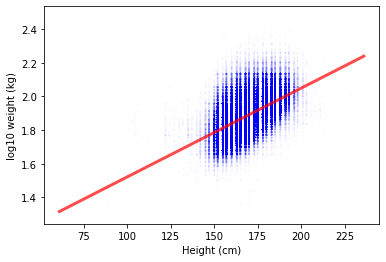

<Figure size 576x432 with 0 Axes>

In [98]:
thinkplot.Scatter(heights, log_weights, alpha=0.01, s=5)
fxs, fys = thinkstats2.FitLine(heights, inter, slope)
thinkplot.Plot(fxs, fys, color='red')
thinkplot.Config(xlabel='Height (cm)', ylabel='log10 weight (kg)')
thinkplot.show()

Make the same plot but apply the inverse transform to show weights on a linear (not log) scale.

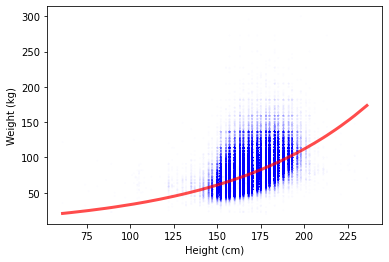

<Figure size 576x432 with 0 Axes>

In [99]:
# Show heights vs weights (non-log) scatter graph with fit line
thinkplot.Scatter(heights, weights, alpha=0.01, s=5)
fxs, fys = thinkstats2.FitLine(heights, inter, slope)
thinkplot.Plot(fxs, 10**fys, color='red')
thinkplot.Config(xlabel='Height (cm)', ylabel='Weight (kg)')
thinkplot.show()

Plot percentiles of the residuals.

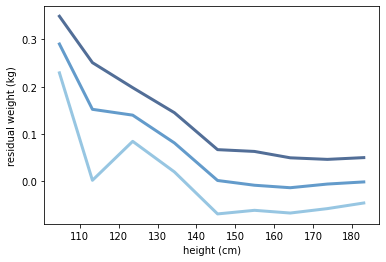

In [100]:
res = thinkstats2.Residuals(heights, log_weights, inter, slope)
df['residual'] = res

bins = np.arange(100, 200, 10)
indices = np.digitize(df.htm3, bins)
groups = df.groupby(indices)

means = [group.htm3.mean() for i, group in groups][1:-1]
cdfs = [thinkstats2.Cdf(group.residual) for i, group in groups][1:-1]

thinkplot.PrePlot(3)
for percent in [75, 50, 25]:
    ys = [cdf.Percentile(percent) for cdf in cdfs]
    label = '%dth' % percent
    thinkplot.Plot(means, ys, label=label)

thinkplot.Config(xlabel='height (cm)', ylabel='residual weight (kg)', legend=False)

Compute correlation.

In [101]:
corr = thinkstats2.Corr(heights, log_weights)
corr

0.5317282605984

Compute coefficient of determination.

In [102]:
inter, slope = thinkstats2.LeastSquares(heights, log_weights)
res = thinkstats2.Residuals(heights, log_weights, inter, slope)
r2 = thinkstats2.CoefDetermination(log_weights, res)
r2

0.2827349431189682

Confirm that $R^2 = \rho^2$.

In [103]:
print('rho', thinkstats2.Corr(heights, log_weights))
print('R', np.sqrt(r2))

rho 0.5317282605984
R 0.5317282605983701


Compute Std(ys), which is the RMSE of predictions that don't use height.

In [104]:
std_ys = thinkstats2.Std(log_weights)
print('Std(ys)', thinkstats2.Std(log_weights))

Std(ys) 0.1032072503000447


Compute Std(res), the RMSE of predictions that do use height.

In [105]:
std_res = thinkstats2.Std(res)
print('Std(res)', thinkstats2.Std(res))

Std(res) 0.08740777080415557


How much does height information reduce RMSE?

In [106]:
1 - std_res / std_ys

0.15308497658795084

Use resampling to compute sampling distributions for inter and slope.

In [107]:
t = []
for _ in range(100):
    sample = thinkstats2.ResampleRows(df)
    estimates = thinkstats2.LeastSquares(sample.htm3, np.log10(sample.wtkg2))
    t.append(estimates)

inters, slopes = zip(*t)


Plot the sampling distribution of slope.

{'xscale': 'linear', 'yscale': 'linear'}

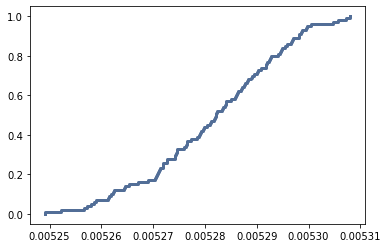

In [108]:
cdf = thinkstats2.Cdf(slopes)
thinkplot.Cdf(cdf)

Compute the p-value of the slope.

In [109]:
pvalue = cdf[0]

Compute the 90% confidence interval of slope.

In [110]:
ci = cdf.Percentile(5), cdf.Percentile(95)
print(ci)

(0.005258086177097046, 0.005299725391161432)


Compute the mean of the sampling distribution.

In [111]:
mean = thinkstats2.Mean(slopes)
print(mean)

0.005281434658409724


Compute the standard deviation of the sampling distribution, which is the standard error.

In [112]:
std = thinkstats2.Std(slopes)
print(std)

1.3121781023153173e-05


Resample rows without weights, compute mean height, and summarize results.

In [113]:
def Summarize(estimates, actual=None):
    mean = thinkstats2.Mean(estimates)
    stderr = thinkstats2.Std(estimates, mu=actual)
    cdf = thinkstats2.Cdf(estimates)
    ci = cdf.ConfidenceInterval(90)
    print('mean, SE, CI', mean, stderr, ci)

estimates = [thinkstats2.ResampleRows(df).htm3.mean() for _ in range(100)]
Summarize(estimates)

mean, SE, CI 168.95689560217465 0.013290913478932395 (168.93535894015642, 168.9788369813456)


Resample rows with weights.  Note that the weight column in this dataset is called `finalwt`.

In [114]:
estimates = [thinkstats2.ResampleRowsWeighted(df, 'finalwt').htm3.mean() for _ in range(100)]
Summarize(estimates)

mean, SE, CI 170.49770516279634 0.016802515327360445 (170.46904242203763, 170.5236160795489)
